# Notebook 1 - Exploring causal graphs and relationships

In this notebook we'll work through some basic examples of causal relationships, in the form of causal graphs.

In [ ]:
# First, we'll need to install the relevant packages
!apt-get install graphviz
!pip install causalgraphicalmodels matplotlib numpy scipy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


The `causalgraphicalmodels` package is really useful when you're learning causal inference concepts, but unfortunately it's been broken since python 3.10.x. Let's fix it in one line. I really should open a PR with this fix...

In [ ]:
!sed -i '/from collections import Iterable/c\from collections.abc import Iterable' /usr/local/lib/python3.10/dist-packages/causalgraphicalmodels/cgm.py

In [ ]:
# Some important imports

from causalgraphicalmodels.csm import StructuralCausalModel, linear_model, logistic_model
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, pearsonr

%matplotlib inline

In [ ]:
# Let's create a helper function to calculate some correlations.

# A reminder from Statistcs 101: A Pearson correlation coefficient is a measure of association between two continuous, normally-distributed variables.
# The coefficient value can vary between -1 to 1. -1 indicates a perfect negative/inverse correlation between two variables,
# while 0 indicates no correlation, and 1 indicates a perfect positive correlation. This coefficient also comes with a p-value, measuring statistical significance.
# A smaller p-value indicates greater statistical significance (with values below 0.05 generally being used as a threshold for significance).

def clean_corr(corr_results):
    """
    Takes the output of the scipy.stats.pearsonr function (Pearson correlation) and cleans it up for easy viewing

    Args:
        corr_results: Tuple of floats, the output from scipy.stats.pearsonr

    Returns: None
    """
    print(f"r = {round(corr_results[0], 3)} (p =  {round(corr_results[1], 3)})")


## Classic confounding

Let's begin by creating a simple causal model for confounding. Remember, a covariate confounds a relationship between two variables of interest when it causes both. This can induce a spurious association between these two variables if none truly exists.

Let's return to the hotel confounding example we discussed in the deck.

In the following example, we're interested in understanding the relationship between hotel booking price (measured in terms of USD) and the number of bookings (this is a count, but let's treat it like a continuous variable). The "treatment" is the price, and the outcome is the bookings. In this example, this relationship is confounded by temperature.


In [ ]:
# Our toy confounding model. Using the `causalgraphicalmodels` API, we can create toy relationships between treatment, confounder, and outcome.

confounding_example = StructuralCausalModel({
    "temperature": lambda n_samples: np.random.normal(loc = 23, scale = 3, size=n_samples),
    "price": linear_model(parents = ["temperature"], weights = [2], noise_scale = 5),
    "bookings": linear_model(parents = ["price", "temperature"], weights = [-1, 5], noise_scale = 5),
})


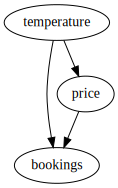

In [ ]:
# Let's draw a causal DAG to represent these relationships
ce_cgm = confounding_example.cgm
ce_cgm.draw()

Now that we've specified the relationships between these variables, we can simulate a dataset with these relationships...

In [ ]:
data = confounding_example.sample(n_samples=100000)

# Let's round these columns to make them seem more real
data["temperature"] = data["temperature"].round(1)
data["price"] = data["price"].round(2)
data["bookings"] = data["bookings"].astype(int)
data.head()

,temperature,price,bookings
0,21.8,42.99,62
1,22.2,44.88,57
2,20.2,31.82,61
3,19.0,35.92,61
4,23.3,44.97,75


Let's calculate the Pearson correlation coefficient between price and the number of bookings

In [ ]:
clean_corr(
    pearsonr(data['price'], data['bookings'])
)

r = 0.333 (p =  0.0)


From the above we can see that there is an apparent moderately strong, positive association between the price and the number of bookings...
As a sanity check, let's plot that relationship:

Text(0.5, 1.0, 'Raw correlation between price and bookings each week')

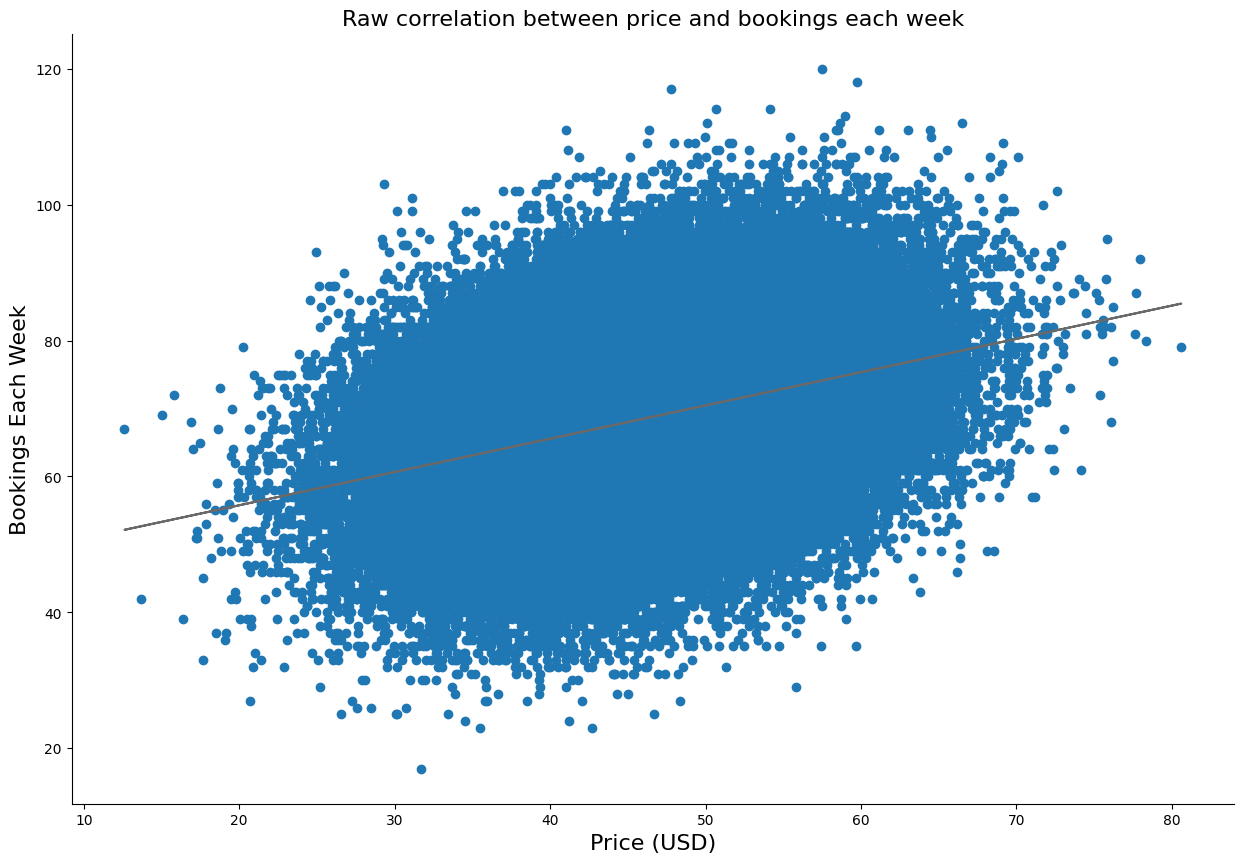

In [ ]:
# Some plot formatting
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Let's include a line of best fit too
a, b = np.polyfit(data['price'], data['bookings'], 1)
plt.plot(data['price'], a*data['price']+b, color = "dimgray")

plt.scatter(data['price'], data['bookings'])
plt.ylabel("Bookings Each Week", fontsize=16)
plt.xlabel("Price (USD)", fontsize=16)
plt.title("Raw correlation between price and bookings each week", fontsize = 16)

As we discussed already, the reason you don't see a negative/inverse correlation here is because of confounding by temperature. We can disrupt the confounding by controlling for temperature.

There is a sophisticated way to control for a variable and a crude way. Here we'll do the crude but know that later in the tutorial we're going to do this through modeling (i.e. the sophisticated way). The crude approach here is to simply restrict the temperature in our dataset so it loses variability and can't exert an effect. This is also named "stratifying on a confounder". It's crude because you lose a ton of your data this way...

In [ ]:
data2 = data[data['temperature'] == 20]

After we do this, the association between coffee and lung cancer risk vanishes entirely!

In [ ]:
clean_corr(
    pearsonr(data2['price'], data2['bookings'])
)



r = -0.716 (p =  0.0)


Text(0.5, 1.0, 'Adjusted correlation between price and bookings each week')

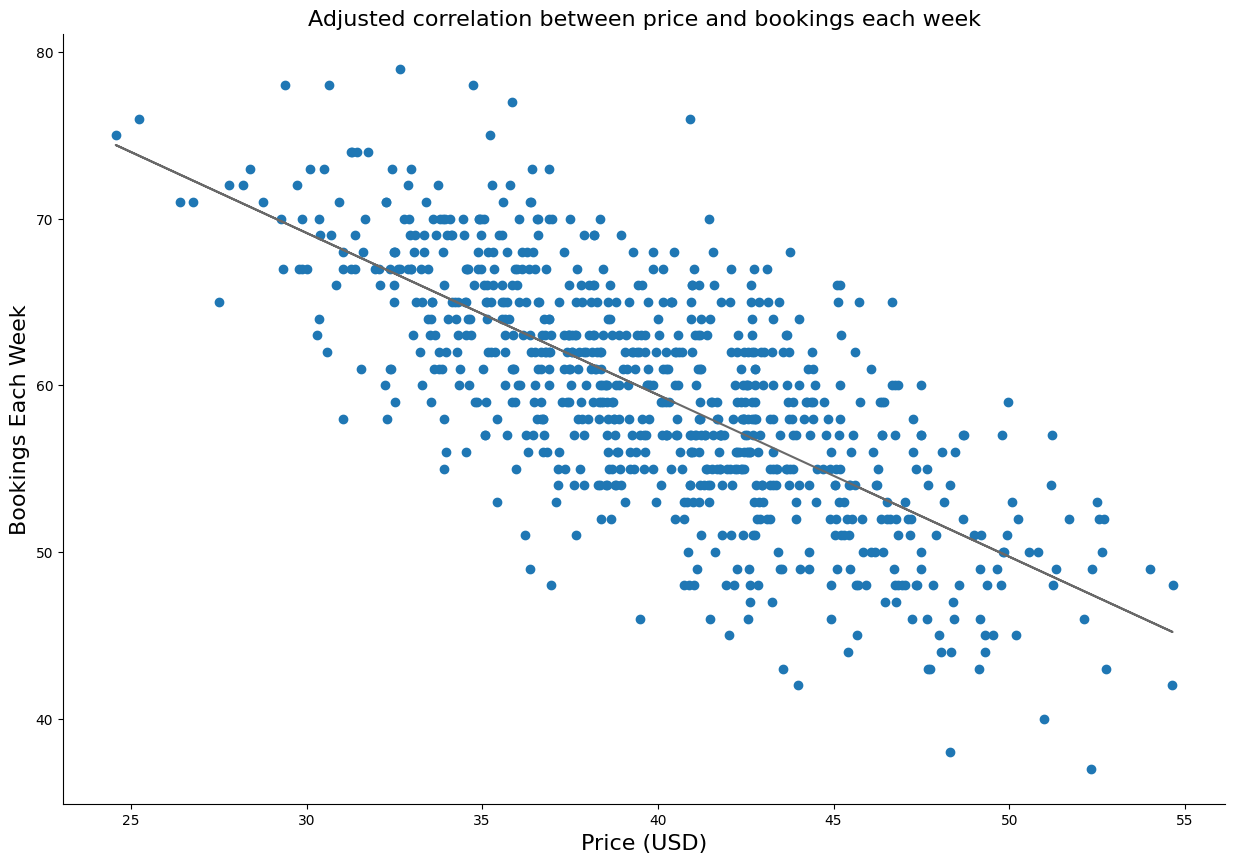

In [ ]:
# Some plot formatting
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Let's include a line of best fit too
a, b = np.polyfit(data2['price'], data2['bookings'], 1)
plt.plot(data2['price'], a*data2['price']+b, color = "dimgray")

plt.scatter(data2['price'], data2['bookings'])
plt.ylabel("Bookings Each Week", fontsize=16)
plt.xlabel("Price (USD)", fontsize=16)
plt.title("Adjusted correlation between price and bookings each week", fontsize = 16)


## Collider

Now let's consider a collider causal relationship. Remember, controlling for a collider can induce a false association between two variables if you control / stratify on it.

Let's say you work at one of the clothing box subscription service companies. These are companies where customers are able to sign up for free, have their an algorithm determinations as to what clothes they might like, and then the company sends the customer a box of 5 highly-recommended clothes. The customer can buy and keep whatever they want from the box, and whatever they don't want they can send back (shipping is free of charge).  

We're going to be looking into a set of three variables in this context:
* Number of rated clothing items: When the user initially signs up and throughout their subscription, they can browse through clothes and rate them with a thumbs up and thumbs down to indicate whether they like the item they're viewing. This helps the algorithm improve over time.
* Number of purchases: This is the total number of items a customer has decided to buy and keep.
* The number of emails a customer receives from the company: The company has a policy of sending customers more emails the more they engage with the service. They figure that if you're really engaged with (rating lots of clothes, buying lots of items) then you'll probably love more emails and announcements from them. They think it'll further strengthen a customer's relationship with the brand. In our data, let's make this a binary variable (0 means low number of emails sent, while 1 means a high number of emails sent).
* Some unrelated variable: A variable that is related to the number of emails a customer receives that isn't relevant.

In this example, the collider is the "number of emails", since it is caused by both the number of rated items and the number of purchased items. Each row in the dataset we're about to produce corresponds to one customer.



In [ ]:
# Let's set up our variables and causal relationships for this example
collider_example = StructuralCausalModel({
    "number_rated_items": lambda n_samples: np.random.normal(loc=30, scale=5, size=n_samples),
    "number_purchases": linear_model(parents = ["number_rated_items"], weights = [1], noise_scale = 5),
    "some_unrelated_variable": lambda n_samples: np.random.normal(loc=100, scale=20, size=n_samples),
    "number_emails": logistic_model(parents = ["number_rated_items", "number_purchases", "some_unrelated_variable"], weights = [1.2,1.5,-1])

})

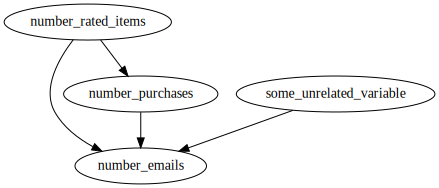

In [ ]:
ce_cgm = collider_example.cgm
ce_cgm.draw()

In [ ]:
data = collider_example.sample(n_samples=10000)

# Let's round these columns to make them seem more real
data = data.astype(int)
data.head()

,number_rated_items,some_unrelated_variable,number_purchases,number_emails
0,19,117,20,0
1,23,118,29,0
2,36,62,35,1
3,16,108,10,0
4,31,112,25,0


### <b>EXERCISE</b>

<b> Determine the raw association between the number of rated items and the number of purchases </b>


In [ ]:
clean_corr(
    pearsonr(data["number_rated_items"], data["number_purchases"])
)

r = 0.709 (p =  0.0)


Text(0.5, 1.0, 'Raw correlation between # of ratings and # of purchases')

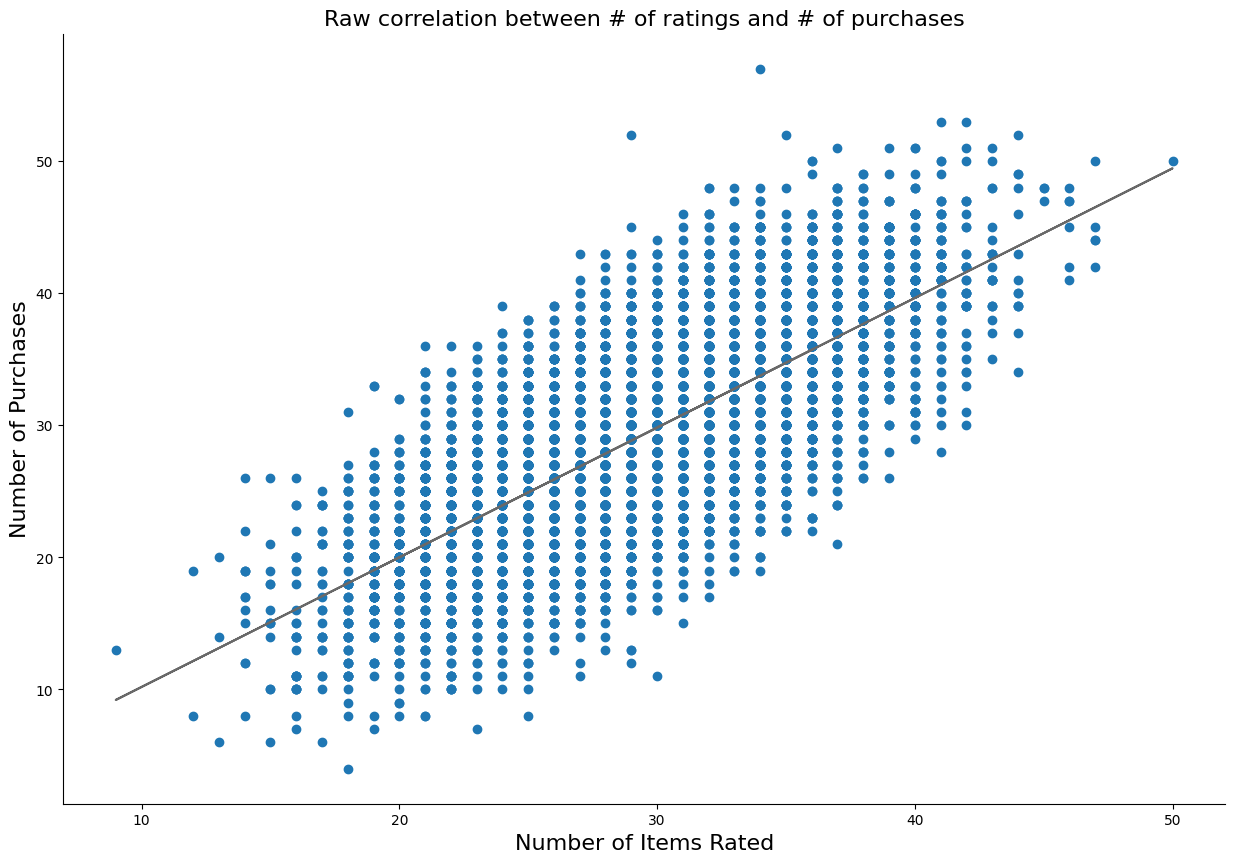

In [ ]:
# Some plot formatting
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Let's include a line of best fit too
a, b = np.polyfit(data['number_rated_items'], data['number_purchases'], 1)
plt.plot(data['number_rated_items'], a*data['number_rated_items']+b, color = "dimgray")

plt.scatter(data['number_rated_items'], data['number_purchases'])
plt.ylabel("Number of Purchases", fontsize=16)
plt.xlabel("Number of Items Rated", fontsize=16)
plt.title("Raw correlation between # of ratings and # of purchases", fontsize = 16)

The correlation between numbers of items rated and number of purchases is pretty strong. This also captures the genuine causal relationship between the two, because there is nothing confounding their relationship occurring.

Let's say you weren't thinking carefully and decide to control for the number of emails sent to customers. If you do, you've now controlled for a collider... bad idea. This is induce bias.

### <b>EXERCISE</b>

<b> Control for the "number of emails sent to customer" variable in your dataset. Tip: remember, you can restrict the dataset like you did for the confounder in the earlier example. For example, filter the dataset to only one value on the collider... </b>


In [ ]:
data2 = data[data["number_emails"] == 1]

Now that you've controlled for the collider, you will have induced bias in any correlation you attempt to estimate between the number of rated items and the number of purchases. Your pearson correlation coefficient will have changed from before (the difference is your bias).

In [ ]:
clean_corr(
    pearsonr(data2["number_rated_items"], data2["number_purchases"])
)

r = 0.615 (p =  0.0)


As you can see, the correlation has been attenuated! The slopes are different, as you can see below:

Text(0.5, 1.0, 'Rating and Purchase slope before and after collider bias')

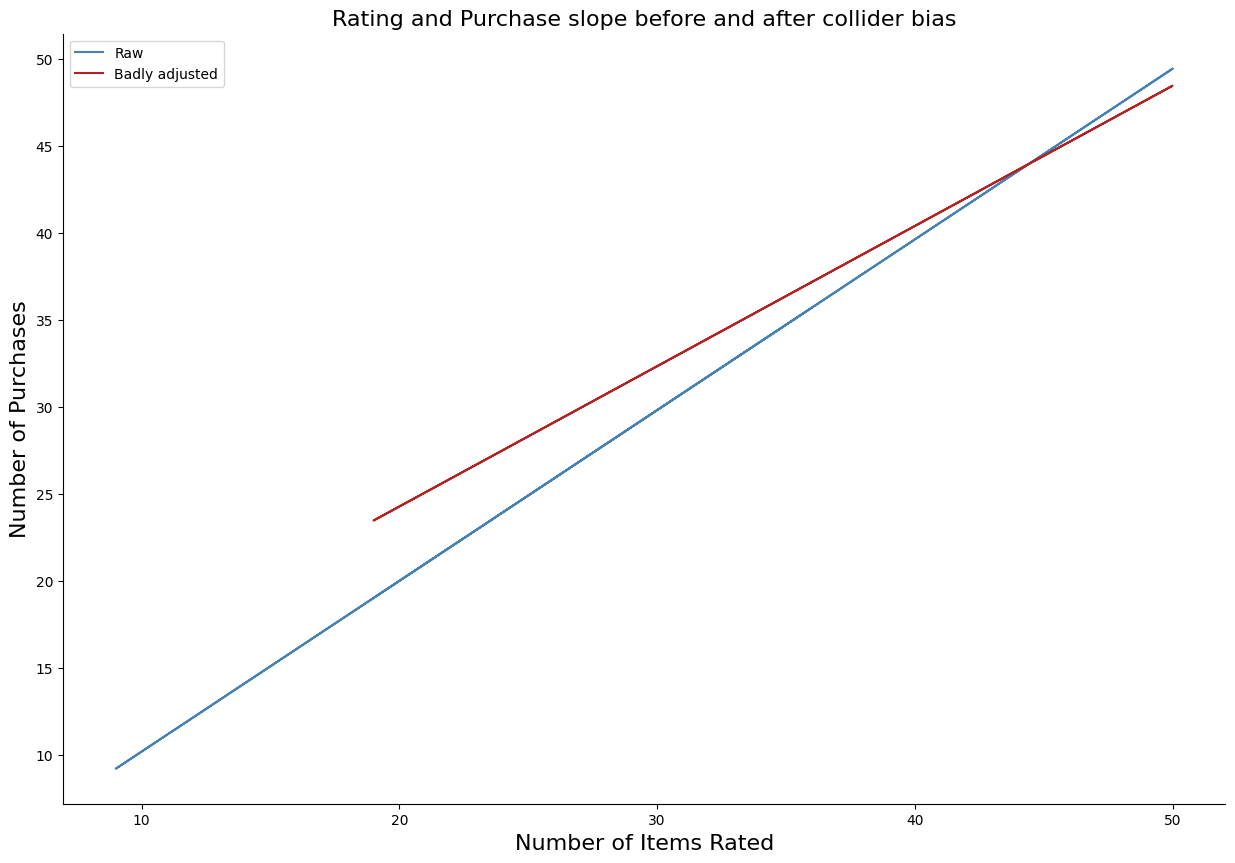

In [ ]:
# Some plot formatting
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Let's include a line of best fit too
a, b = np.polyfit(data['number_rated_items'], data['number_purchases'], 1)
plt.plot(data['number_rated_items'], a*data['number_rated_items']+b, color = "steelblue", label="Raw")

a, b = np.polyfit(data2['number_rated_items'], data2['number_purchases'], 1)
plt.plot(data2['number_rated_items'], a*data2['number_rated_items']+b, color = "firebrick", label="Badly adjusted")

plt.legend(loc="upper left")
plt.ylabel("Number of Purchases", fontsize=16)
plt.xlabel("Number of Items Rated", fontsize=16)
plt.title("Rating and Purchase slope before and after collider bias", fontsize = 16)


## Mediator

Now let's assume you work at a new ride-sharing service. This service is a bit different from the others in that you need to subscribe and pay a monthly fee to even get access to drivers. The company claims that it's a great service for frequently-traveling individuals. In this case let's say that each row in our simulated dataset corresponds to a unique city in the country, with the following three variables:

* Advertise: count indicating how many of the city's residents received advertising for the service
* Subscribers: count of number of subscribed users in the city since the start of the service.
* Rides: count of number of rides that have occurred in this city since the start of the service.

Let's say that `advertise` is the treatment, and `rides` is the outcome.

### <b>EXERCISE</b>

<b> Create a toy model demonstrating the causal relationship of "mediation". Look to the prior examples to see how to use the `causalgraphicalmodels` API.
</b>

In [ ]:
mediator_example = StructuralCausalModel({
    "advertise": lambda n_samples: np.random.normal(loc=30, scale=5, size=n_samples),
    "subscribers": linear_model(parents = ["advertise"], weights = [0.75], noise_scale = 5),
    "rides": linear_model(parents = ["subscribers"], weights = [0.75], noise_scale = 5)
})

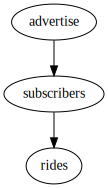

In [ ]:
me_cgm = mediator_example.cgm
me_cgm.draw()

### <b>EXERCISE</b>

<b> What does the raw correlation between the treatment and the outcome look like?
</b>

In [ ]:
data = mediator_example.sample(n_samples=100000)
data = data.astype(int)
data.head()

,advertise,subscribers,rides
0,28,21,13
1,24,18,15
2,23,15,14
3,26,19,9
4,30,18,11


In [ ]:
clean_corr(
    pearsonr(data["advertise"], data["rides"])
)

r = 0.411 (p =  0.0)


Text(0.5, 1.0, 'Raw correlation between advertisements shown and rides taken')

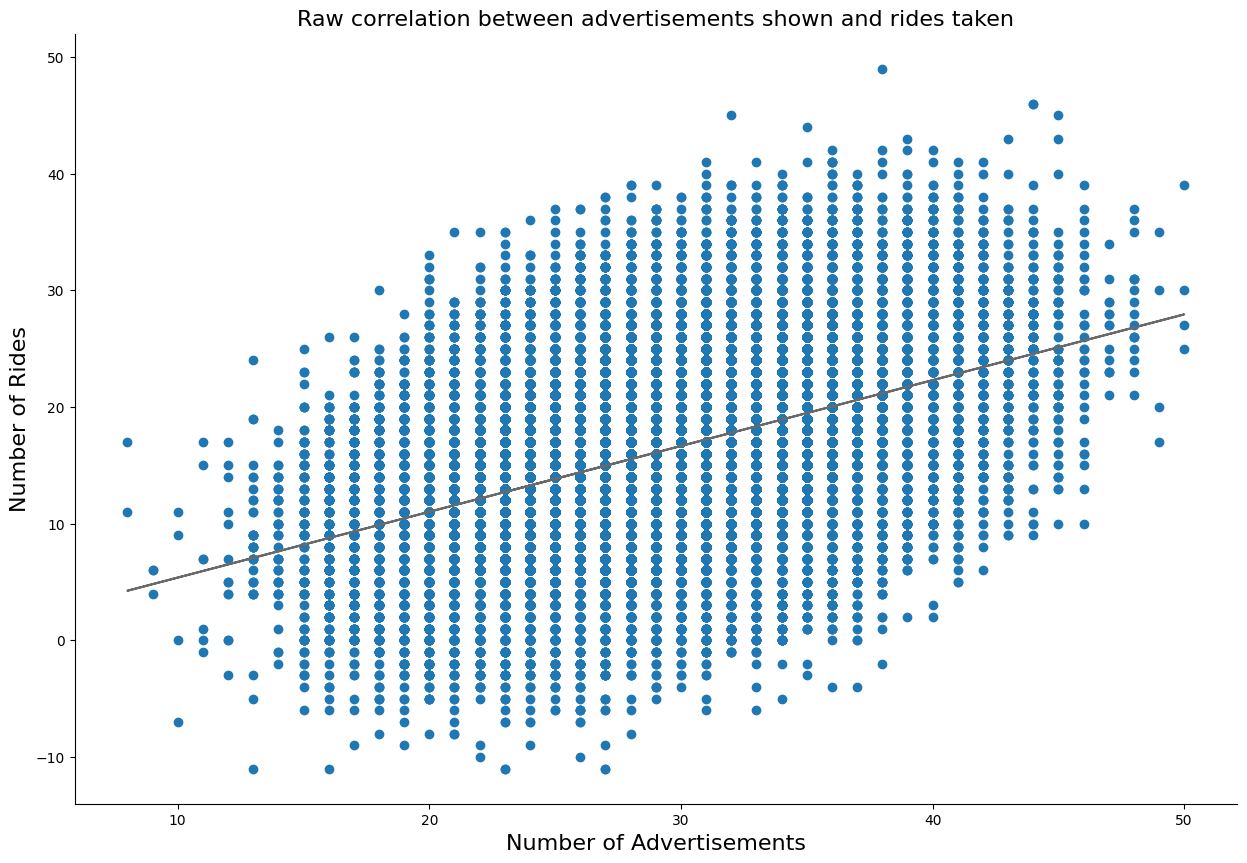

In [ ]:
# Some plot formatting
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Let's include a line of best fit too
a, b = np.polyfit(data['advertise'], data['rides'], 1)
plt.plot(data['advertise'], a*data['advertise']+b, color = "dimgray")

plt.scatter(data['advertise'], data['rides'])
plt.ylabel("Number of Rides", fontsize=16)
plt.xlabel("Number of Advertisements", fontsize=16)
plt.title("Raw correlation between advertisements shown and rides taken", fontsize = 16)

### <b>EXERCISE</b>

<b> Control for the mediator below:
</b>

In [ ]:
data2 = data[data["subscribers"] == 24]

### <b>EXERCISE</b>

<b> Now that you've controlled for the primary mediating pathway between advertisements and rides, what do you expect the correlation between advertisements and rides will look like? Please explore that with a correlation coefficient and a plot.
</b>

In [ ]:
clean_corr(
    pearsonr(data2["advertise"], data2["rides"])
)

r = 0.019 (p =  0.131)


Text(0.5, 1.0, 'Advertisement and rides slope before and after collider bias')

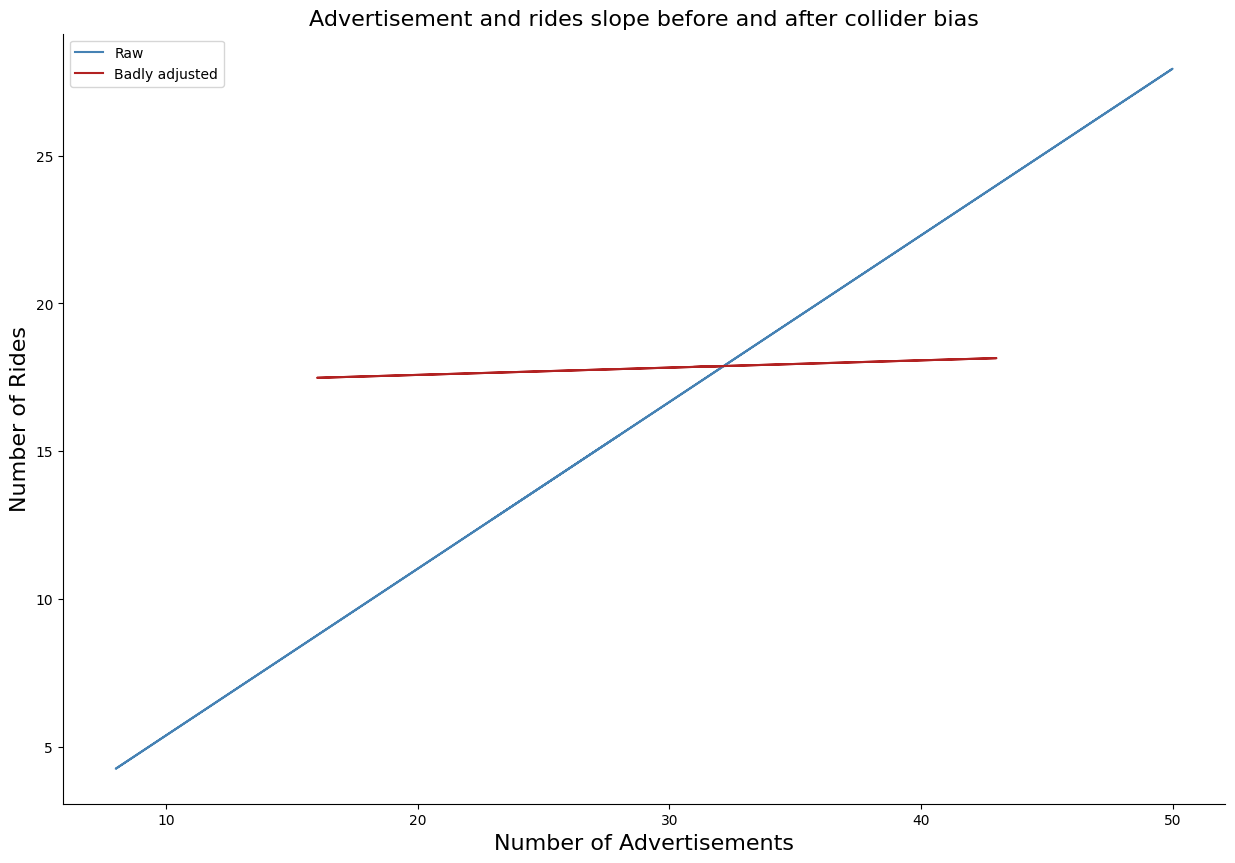

In [ ]:
# Some plot formatting
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Let's include a line of best fit too
a, b = np.polyfit(data['advertise'], data['rides'], 1)
plt.plot(data['advertise'], a*data['advertise']+b, color = "steelblue", label="Raw")

a, b = np.polyfit(data2['advertise'], data2['rides'], 1)
plt.plot(data2['advertise'], a*data2['advertise']+b, color = "firebrick", label="Badly adjusted")

plt.legend(loc="upper left")
plt.ylabel("Number of Rides", fontsize=16)
plt.xlabel("Number of Advertisements", fontsize=16)
plt.title("Advertisement and rides slope before and after collider bias", fontsize = 16)


## Putting it all together...

Let's draw up a more complex example now

In [ ]:
# Let's set up our variables and causal relationships for this example
complex_example = StructuralCausalModel({
    "A": lambda n_samples: np.random.normal(loc=30, scale=5, size=n_samples),
    "B": lambda n_samples: np.random.normal(loc=100, scale=20, size=n_samples),
    "C": lambda n_samples: np.random.binomial(1, p=0.30, size=n_samples),
    "D": linear_model(parents = ["B", "C"], weights = [2, 0.5], noise_scale = 5),
    "E": linear_model(parents = ["A", "D"], weights = [1, 2.2], noise_scale = 5),
    "F": logistic_model(parents = ["A", "E", "D"], weights = [1.2,1.5,-1])
})

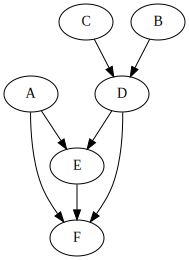

In [ ]:
graph_obj = complex_example.cgm
graph_obj.draw()

### <b>EXERCISE</b>

<b> Let's say you've got a dataset with columns A-F and with a data scientist and a domain expert on your team, you construct the above DAG to represent the causal relationships between these variables.

If you wanted to understand the causal relationship between C and E, would you need to control for any covariates?
</b>

You wouldn't have to control for any

In [ ]:
# Let's set up our variables and causal relationships for this example
complex_example = StructuralCausalModel({
    "B": lambda n_samples: np.random.normal(loc=100, scale=20, size=n_samples),
    "C": lambda n_samples: np.random.binomial(1, p=0.30, size=n_samples),
    "D": linear_model(parents = ["B", "C"], weights = [2, 0.5], noise_scale = 5),
})

data = complex_example.sample(n_samples=100000)
data.head()

,B,C,D
0,78.302397,1,162.281327
1,101.580160,0,200.213321
2,96.780864,1,191.946420
3,136.215249,0,279.258135
4,72.826054,1,143.467980
